##Weather forecast

Questo Notebook userà vari modelli di machine learning per prevedere il meteo di 7 diverse città italiane.
Il dataset ci fornisce le varie informazioni del meteo delle diverse città dal 2018-1-1 fino 2023-1-1, come ad esempio la temperatura, la pressione, il vento ecc..

#### Import dependencies and load data

In [240]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/SCC')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
!pip install WorldWeatherPy
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [242]:
import pandas as pd
import numpy as np
import json
import WorldWeatherPy
from matplotlib import pyplot as plt
import seaborn as sns
import os

from WorldWeatherPy import DetermineListOfAttributes
from WorldWeatherPy import RetrieveByAttribute

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics._plot.confusion_matrix import confusion_matrix

In [243]:
api_key = 'bd35020cdd3643f4b69142436222912'
attributes = ['date','time', 'tempC', 'windspeedKmph','weatherDesc', 'precipMM', 'humidity', 'visibility', 'pressure', 'cloudcover']

conditions = ['Sunny','Clear','Cloudy','Rain','Snow']
location_list = ['milan','turin','florence','bologna','rome','naples','palermo']
#location_list = ['milan']

frequency = 3
start_date = '2016-1-1' 
end_date = '2023-1-1'              

In [244]:
for location in location_list:
    data = RetrieveByAttribute(api_key, attributes, location, start_date, end_date , frequency).retrieve_hist_data()
    data.to_csv(f'data/{location}.csv', encoding='utf-8', index=False) 



Retrieving weather data for milan


Retrieving data for milan from: 2016-01-01 to: 2016-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.931154
Retrieving data for milan from: 2016-02-01 to: 2016-02-29
Time elapsed (hh:mm:ss.ms) 0:00:01.956076
Retrieving data for milan from: 2016-03-01 to: 2016-03-31
Time elapsed (hh:mm:ss.ms) 0:00:02.858652
Retrieving data for milan from: 2016-04-01 to: 2016-04-30
Time elapsed (hh:mm:ss.ms) 0:00:04.241496
Retrieving data for milan from: 2016-05-01 to: 2016-05-31
Time elapsed (hh:mm:ss.ms) 0:00:05.323950
Retrieving data for milan from: 2016-06-01 to: 2016-06-30
Time elapsed (hh:mm:ss.ms) 0:00:06.392456
Retrieving data for milan from: 2016-07-01 to: 2016-07-31
Time elapsed (hh:mm:ss.ms) 0:00:07.624854
Retrieving data for milan from: 2016-08-01 to: 2016-08-31
Time elapsed (hh:mm:ss.ms) 0:00:08.884487
Retrieving data for milan from: 2016-09-01 to: 2016-09-30
Time elapsed (hh:mm:ss.ms) 0:00:10.202087
Retrieving data for milan from: 2016-10-01 to: 2016-10-31
Time

In [245]:
data = pd.read_csv(f'data/milan.csv')
data.head(-10)

,date,time,tempC,windspeedKmph,weatherDesc,precipMM,humidity,visibility,pressure,cloudcover,city
0,2016-01-01,0,2,5,[{'value': 'Partly cloudy'}],0.0,89,10,1027,49,milan
1,2016-01-01,3,1,2,[{'value': 'Clear'}],0.0,91,10,1026,17,milan
2,2016-01-01,6,1,1,[{'value': 'Sunny'}],0.0,91,10,1027,16,milan
3,2016-01-01,9,3,2,[{'value': 'Sunny'}],0.0,71,10,1026,12,milan
4,2016-01-01,12,6,5,[{'value': 'Sunny'}],0.0,63,10,1025,12,milan
...,...,...,...,...,...,...,...,...,...,...,...
20449,2022-12-31,3,6,8,[{'value': 'Clear'}],0.0,75,10,1025,14,milan
20450,2022-12-31,6,6,7,[{'value': 'Sunny'}],0.0,76,10,1027,7,milan
20451,2022-12-31,9,6,3,[{'value': 'Sunny'}],0.0,75,10,1029,10,milan
20452,2022-12-31,12,10,1,[{'value': 'Sunny'}],0.0,62,10,1030,8,milan


In [246]:
null_values = data.isnull()
null_counts = null_values.sum()
null_counts

date             0
time             0
tempC            0
windspeedKmph    0
weatherDesc      0
precipMM         0
humidity         0
visibility       0
pressure         0
cloudcover       0
city             0
dtype: int64

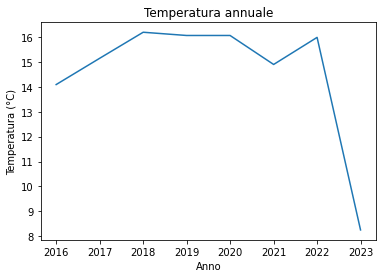

In [247]:
df = data

df['date']
df['date'] = pd.to_datetime(df['date'])
df_years = df.resample('A', on='date', label='left').mean()

# Seleziona l'indice del DataFrame come eixo x e la colonna 'tempC' come eixo y
x = df_years.index
y = df_years['tempC']

# Crea il grafico
plt.plot(x, y)

# Aggiungi un titolo e etichette per gli assi
plt.title('Temperatura annuale')
plt.xlabel('Anno')
plt.ylabel('Temperatura (°C)')

# Mostra il grafico
plt.show()


In [248]:
for location in location_list:

  data = pd.read_csv(f'data/{location}.csv')
  tmp = []

  for i, row in data.iterrows():
          found = False
          for j in conditions:
              if j.lower() in row['weatherDesc'].lower():
                  data.at[i, 'weatherDesc'] = j
                  found = True
                  break
          if not found:
                  tmp.append(i)

  data = data.drop(tmp)
  data = data.drop_duplicates()
  data = data.dropna()
  data[data.select_dtypes(include='number').columns] = data[data.select_dtypes(include='number').columns].replace(-0, 0)
  data = data.reset_index(drop=True)
  data.to_csv(f'data/{location}.csv', index=False)


In [249]:
data = pd.read_csv(f'data/milan.csv')
data.head()

,date,time,tempC,windspeedKmph,weatherDesc,precipMM,humidity,visibility,pressure,cloudcover,city
0,2016-01-01,0,2,5,Cloudy,0.0,89,10,1027,49,milan
1,2016-01-01,3,1,2,Clear,0.0,91,10,1026,17,milan
2,2016-01-01,6,1,1,Sunny,0.0,91,10,1027,16,milan
3,2016-01-01,9,3,2,Sunny,0.0,71,10,1026,12,milan
4,2016-01-01,12,6,5,Sunny,0.0,63,10,1025,12,milan


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


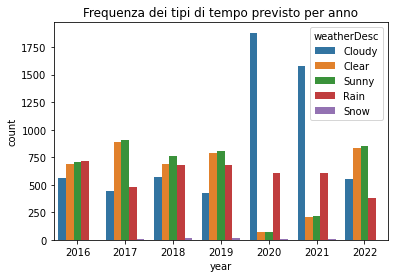

In [250]:
df = data

# Converte la colonna 'date' in una colonna di tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Crea una nuova colonna 'year' che contenga l'anno di ogni riga
df['year'] = df['date'].dt.year

# Crea una lista con tutti gli anni presenti nel dataset
years = df['year'].unique().tolist()

# Rimuovi l'ultimo elemento della lista
years.pop()

# Seleziona solo le righe del dataset con gli anni presenti nella lista 'years'
df = df[df['year'].isin(years)]

# Seleziona la colonna 'year' come eixo x e la colonna 'weatherDesc' come eixo y
x = df['year']
y = df['weatherDesc']

# Crea il grafico a barre
sns.countplot(x, hue=y)

# Aggiungi un titolo
plt.title('Frequenza dei tipi di tempo previsto per anno')

# Mostra il grafico
plt.show()


## DATA PROCESSING

In [ ]:
def data_pre_processing(location):

  data = pd.read_csv(f'data/{location}.csv')
 
  data = data.drop(['date','time','city'], axis=1) # Tuttavia, se si utilizza un modello di Random Forest su un dataset di diverse città, il modello potrebbe essere in grado di apprendere autonomamente queste differenze e quindi la colonna 'city' potrebbe non essere necessaria.
  y = data[['weatherDesc']]
  x = data.drop(['weatherDesc'], axis=1)
  columns = x.columns
  # Standardizza sia le x che le y utilizzando lo scaler
  scaler = StandardScaler()
  scaler.fit(x)
  X = scaler.transform(x)

  encoder = LabelEncoder()
  y = encoder.fit_transform(y)

  # Salva lo scaler e l'encoder
  os.makedirs(f'scaler_encoder/{location}', exist_ok=True)
  dump(encoder, f'scaler_encoder/{location}/{location}_encoder.joblib')
  dump(scaler, f'scaler_encoder/{location}/{location}_scaler.joblib')

  # Crea il DataFrame delle features standardizzate
  features = pd.DataFrame(X, columns = columns)
        
  return features, y

In [252]:
location = 'milan'
features, y = data_pre_processing(location)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [253]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18718 entries, 0 to 18717
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tempC          18718 non-null  float64
 1   windspeedKmph  18718 non-null  float64
 2   precipMM       18718 non-null  float64
 3   humidity       18718 non-null  float64
 4   visibility     18718 non-null  float64
 5   pressure       18718 non-null  float64
 6   cloudcover     18718 non-null  float64
dtypes: float64(7)
memory usage: 1023.8 KB


In [254]:
# Ottieni le classi codificate
encoder = load('scaler_encoder/milan/milan_encoder.joblib')

classes = encoder.classes_

# Crea un dizionario con il numero associato alla classe
inverse_mapping = {i: classes[i] for i in range(len(classes))}

# Stampa le classi con il valore associato
for key, value in inverse_mapping.items():
  print(f"{value}: {key}")



Clear: 0
Cloudy: 1
Rain: 2
Snow: 3
Sunny: 4


## ML

In [255]:
criteria = ['gini','entropy']

bootstrap = True

penalty = 'l2'
solvers = ['newton-cg', 'lbfgs', 'liblinear']


In [256]:
max_depth_dc_0 = 7
max_depth_dc_1 = 8

In [257]:
n_estimators = 400
max_depth_rf_0 = 6
max_depth_rf_1 = 7
max_features = 'sqrt'

In [258]:
C = 3.0
max_iter = 2500

In [259]:
def decision_tree(location, n_criterion):

  features, y, = data_pre_processing(location)

  X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3,  random_state = 42)

  criterion = criteria[n_criterion]

  if n_criterion == 0:
      max_depth = max_depth_dc_0
  if n_criterion == 1:
      max_depth = max_depth_dc_1

  X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3)

  model = DecisionTreeClassifier(max_depth = 3, criterion = criterion)
  model.fit(X_train, y_train)

  # Save the model
  os.makedirs(f'models/{location}', exist_ok=True)
  dump(model, f'models/{location}/decision_tree_{criterion}.joblib')

  # Get predictions
  y_pred = model.predict(X_test)
  # Get accuracy
  accuracy = accuracy_score(y_test, y_pred)

  return accuracy

In [260]:
def random_forest(location, n_criterion):

    features, y = data_pre_processing(location) 

    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3,  random_state = 42)

    criterion = criteria[n_criterion]

    if n_criterion == 0:
      max_depth = max_depth_rf_0
    if n_criterion == 1:
      max_depth = max_depth_rf_1

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators = n_estimators, max_features = max_features, 
                                   criterion = criterion, max_depth = max_depth, bootstrap = bootstrap )
    model.fit(X_train, y_train)
    
    # Save the model
    os.makedirs(f'models/{location}', exist_ok=True)
    dump(model, f'models/{location}/{location}_random_forest_{criterion}.joblib')

    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [261]:
def logistic_regression(location, n_solver):

    features, y = data_pre_processing(location) 

    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3,  random_state = 42)

    solver = solvers[n_solver]

    model = LogisticRegression(penalty = penalty , C = C, solver = solver , max_iter = max_iter)
    #model = LogisticRegression()
    model.fit(X_train, y_train)

    # Save the model
    os.makedirs(f'models/{location}', exist_ok=True)
    dump(model, f'models/{location}/{location}_logistic_regression_{solver}.joblib')

    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

## Results

In [262]:
def show_results_dc(accuracy_file, location, accuracy_0, accuracy_1):

  with open(accuracy_file, 'w') as f:
        f.write('Decision_tree_gini(accuracy) in ' + location + ': ' + str(accuracy_0) + '\n')
        f.write('Decision_entropy(accuracy) in ' + location + ': ' + str(accuracy_1) + '\n')

  print(f"Decision_tree_gini_{max_depth_dc_0} in {location}: {accuracy_0} ")
  print(f"Decision_tree_entropy_{max_depth_dc_1}(accuracy) in {location}: {accuracy_1} " + '\n')

In [263]:
def show_results_rf(accuracy_file, location, accuracy_0, accuracy_1):

  with open(accuracy_file, 'w') as f:
        f.write('Random_forest_gini(accuracy) in ' + location + ': ' + str(accuracy_0) + '\n')
        f.write('Random_forest_entropy(accuracy) in ' + location + ': ' + str(accuracy_1) + '\n')

  print(f"Random_forest_gini_{n_estimators}_{max_depth_rf_0}(accuracy) in {location}: {accuracy_0} ")
  print(f"Random_forest_entropy_{n_estimators}_{max_depth_rf_1}(accuracy) in {location}: {accuracy_1} " + '\n')

In [264]:
def show_results_lr(accuracy_file, location, accuracy_0, accuracy_1, accuracy_2):

  with open(accuracy_file, 'w') as f:
        f.write('Logistic_regression_newton-cg(accuracy) in ' + location + ': ' + str(accuracy_0) + '\n')
        f.write('Logistic_regression_lbfgs(accuracy) in ' + location + ': ' + str(accuracy_1) + '\n')
        f.write('Logistic_regression_liblinear(accuracy) in ' + location + ': ' + str(accuracy_2) + '\n')

  print(f"Logistic_regression_newton-cg_{C}_{max_iter}(accuracy) in {location}: {accuracy_0} ")
  print(f"Logistic_regression_lbfgs_{C}_{max_iter}(accuracy) in {location}: {accuracy_1} ")
  print(f"Logistic_regression_liblinear_{C}_{max_iter}(accuracy) in {location}: {accuracy_2} " + '\n')

In [265]:
def classify(location):
    os.makedirs(f'results/{location}', exist_ok=True)
    accuracy_file = f'results/{location}/accuracy.txt'
    
    accuracy_dc_0 = decision_tree(location, 0)
    accuracy_dc_1 = decision_tree(location, 1)

    accuracy_rf_0 = random_forest(location, 0)
    accuracy_rf_1 = random_forest(location, 1)

    accuracy_lr_0 = logistic_regression(location, 0)
    accuracy_lr_1 = logistic_regression(location, 1)
    accuracy_lr_2 = logistic_regression(location, 2)

    # Given the outputs from "decision_tree" and "logistic_regression"
    # the component "show_results" is called to print the results.
    show_results_dc(accuracy_file,location, accuracy_dc_0, accuracy_dc_1)
    show_results_rf(accuracy_file,location, accuracy_rf_0, accuracy_rf_1)
    show_results_lr(accuracy_file,location, accuracy_lr_0, accuracy_lr_1, accuracy_lr_2 )

In [ ]:
for location in location_list:
  classify(location)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Decision_tree_gini_7 in milan: 0.698005698005698 
Decision_tree_entropy_8(accuracy) in milan: 0.6930199430199431 

Random_forest_gini_400_6(accuracy) in milan: 0.7140313390313391 
Random_forest_entropy_400_7(accuracy) in milan: 0.7104700854700855 

Logistic_regression_newton-cg_3.0_2500(accuracy) in milan: 0.6892806267806267 
Logistic_regression_lbfgs_3.0_2500(accuracy) in milan: 0.6892806267806267 
Logistic_regression_liblinear_3.0_2500(accuracy) in milan: 0.6876780626780626 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [267]:
features, y = data_pre_processing(location) 

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3,  random_state = 42)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Decision_tree_entropy - Test Data')
              precision    recall  f1-score   support

           0       0.43      0.94      0.59      1641
           1       0.82      0.56      0.66      1789
           2       0.82      0.95      0.88       894
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00      1545

    accuracy                           0.58      5870
   macro avg       0.41      0.49      0.43      5870
weighted avg       0.49      0.58      0.50      5870



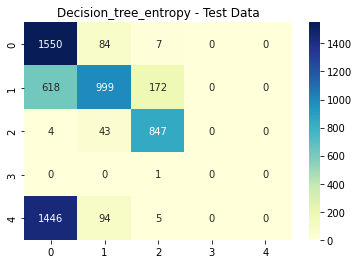

In [268]:
model = load('models/milan/decision_tree_entropy.joblib') # da mettere il modello migliore
y_pred = model.predict(X_test)

test_matrix_0 = confusion_matrix(y_test, y_pred)
#plotting heatmap confusion matrix
print(sns.heatmap(test_matrix_0, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Decision_tree_entropy - Test Data'))

#classification report for rf base model
test_report_base = classification_report(y_test, y_pred)
print(test_report_base)

Text(0.5, 1.0, 'Decision_tree_entropy - Train Data')
              precision    recall  f1-score   support

           0       0.42      0.93      0.58      3865
           1       0.81      0.56      0.66      4046
           2       0.83      0.95      0.88      2020
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00      3758

    accuracy                           0.57     13694
   macro avg       0.41      0.49      0.42     13694
weighted avg       0.48      0.57      0.49     13694



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


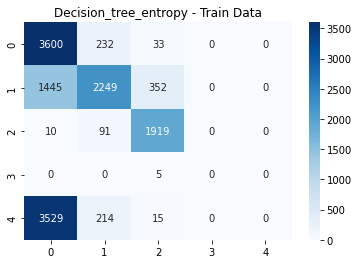

In [269]:
y_tpred_base = model.predict(X_train)

train_matrix_base = confusion_matrix(y_train, y_tpred_base)

#plotting heatmap confusion matrix
print(sns.heatmap(train_matrix_base, annot=True, cmap="Blues",fmt="d").set_title(
'Decision_tree_entropy - Train Data'))

#classification report for rf base model
train_report_base = classification_report(y_train, y_tpred_base)
print(train_report_base)


## Inference

In [270]:
from joblib import dump, load

scaler = load('scaler_encoder/milan/milan_scaler.joblib')
model = load('models/milan/decision_tree_entropy.joblib')
encoder = load('scaler_encoder/milan/milan_encoder.joblib')

In [271]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19564 entries, 0 to 19563
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tempC          19564 non-null  float64
 1   windspeedKmph  19564 non-null  float64
 2   precipMM       19564 non-null  float64
 3   humidity       19564 non-null  float64
 4   visibility     19564 non-null  float64
 5   pressure       19564 non-null  float64
 6   cloudcover     19564 non-null  float64
dtypes: float64(7)
memory usage: 1.0 MB


In [272]:
tempC           = 11
windspeedKmph   = 13
precipMM        = 3
humidity        = 1
visibility      = 5
pressure        = 5
cloudcover      = 1

feat_cols = features.columns
row = [tempC, windspeedKmph, precipMM, humidity, visibility, pressure, cloudcover]

df = pd.DataFrame([row], columns = feat_cols)
X = scaler.transform(df)
features = pd.DataFrame(X, columns = feat_cols)


prediction = model.predict(features)
prediction = encoder.inverse_transform(prediction)

print("Il meteo sarà : " + prediction )

['Il meteo sarà : Rain']
